In [1]:
!pip install matplotlib numpy pandas scikit-learn dask "dask[dataframe]"

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import dask.dataframe as dd
import sklearn as skl
from sklearn.decomposition import PCA
from yellowbrick.regressor import PredictionError
from sklearn.model_selection import learning_curve
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate


In [3]:
dataset = '../Datasets/Small_datasetPreprocessed2.parquet'

if os.path.exists(dataset):
    df = pd.read_parquet(dataset)
    df = df.dropna() 
    print(df.head(1))
    print(df.dtypes)
else:
    print("Dataset not found")


   vendorid  passenger_count  trip_distance  ratecodeid  total_amount  \
0       2.0              1.0           0.52         1.0           5.3   

   pickup_hour  time_in_taxi  tavg  precipitation  new_snow  snow_depth  \
0            9      3.616667  71.5            0.0       0.0         0.0   

   day_type  service_zone_pulocation  service_zone_dolocation  
0         1                      3.0                      3.0  
vendorid                   float64
passenger_count            float64
trip_distance              float64
ratecodeid                 float64
total_amount               float64
pickup_hour                  int32
time_in_taxi               float64
tavg                       float64
precipitation              float64
new_snow                   float64
snow_depth                 float64
day_type                     int32
service_zone_pulocation    float64
service_zone_dolocation    float64
dtype: object


In [4]:
X = df.drop(['total_amount'], axis=1)
y = df['total_amount']

In [5]:
#LINEAR REGRESSOR MODEL
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(score)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

0.8251935311838972
Mean Squared Error (MSE): 11.71177145370775
Mean Absolute Error (MAE): 1.8541864131122294


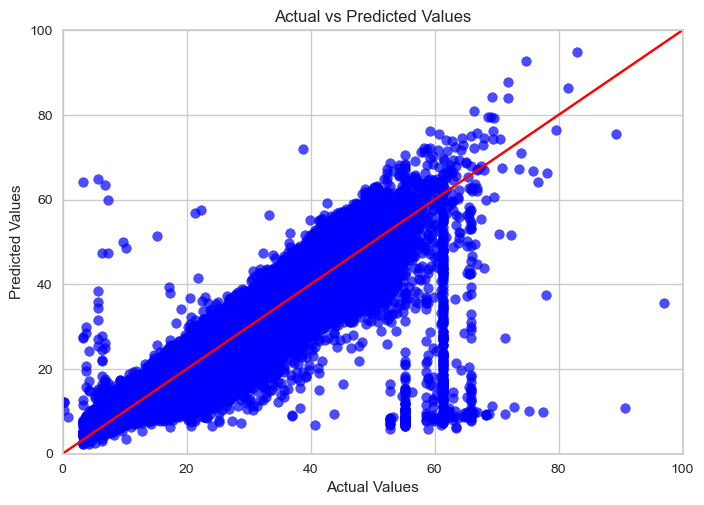

In [6]:
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([min(y_test), 120], [min(y_test), 120], color='red', linestyle='-')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlim([0, 100])  # Constrain x-axis
plt.ylim([0, 100])
plt.show()

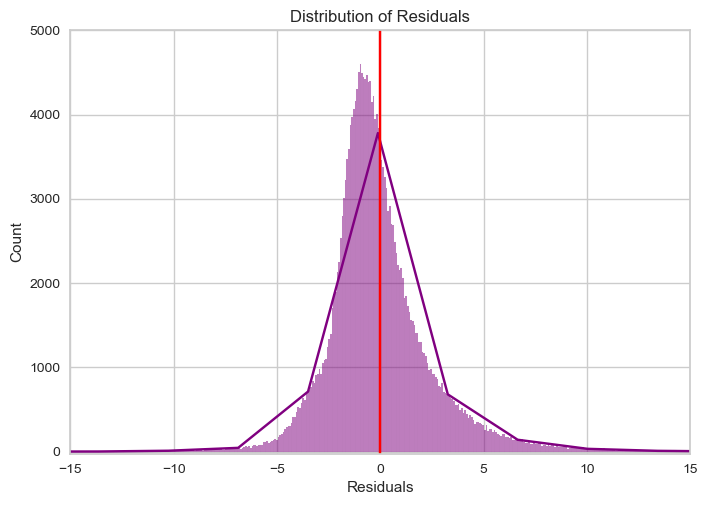

In [9]:
residuals = y_test - y_pred

sns.histplot(residuals, kde=True, color='purple')
plt.axvline(x=0, color='red', linestyle='-')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.xlim([-15, 15])  # Constrain x-axis
plt.ylim([-25, 5000])
plt.show()


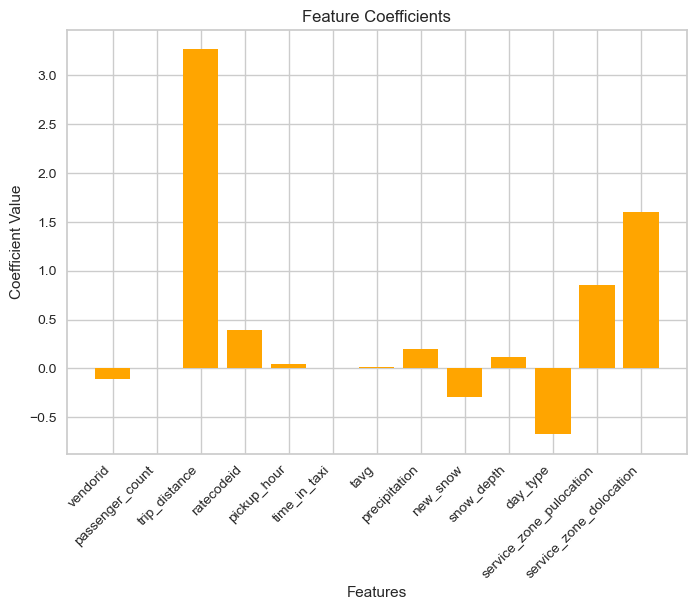

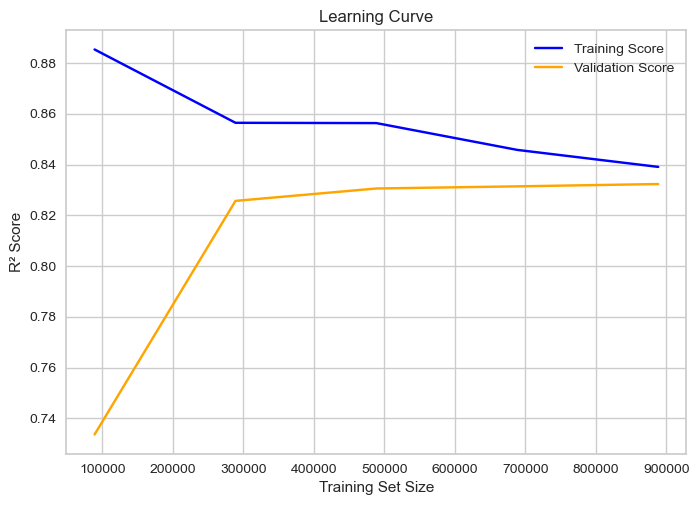

In [12]:
coef = model.coef_
features = X.columns  # Replace with the names of your features

plt.bar(features, coef, color='orange')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Coefficients')
plt.show()



train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='r2', n_jobs=-1)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validation Score', color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [20]:
X_oneHot = X
df_onehot = pd.get_dummies(df, columns=['vendorid'], prefix='vendorid')

X_train, X_test, y_train, y_test = train_test_split(X_oneHot, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print results
print("results with one-hot encoding")
print(score)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

results with one-hot encoding
0.8251935311838972
Mean Squared Error (MSE): 11.71177145370775
Mean Absolute Error (MAE): 1.8541864131122294


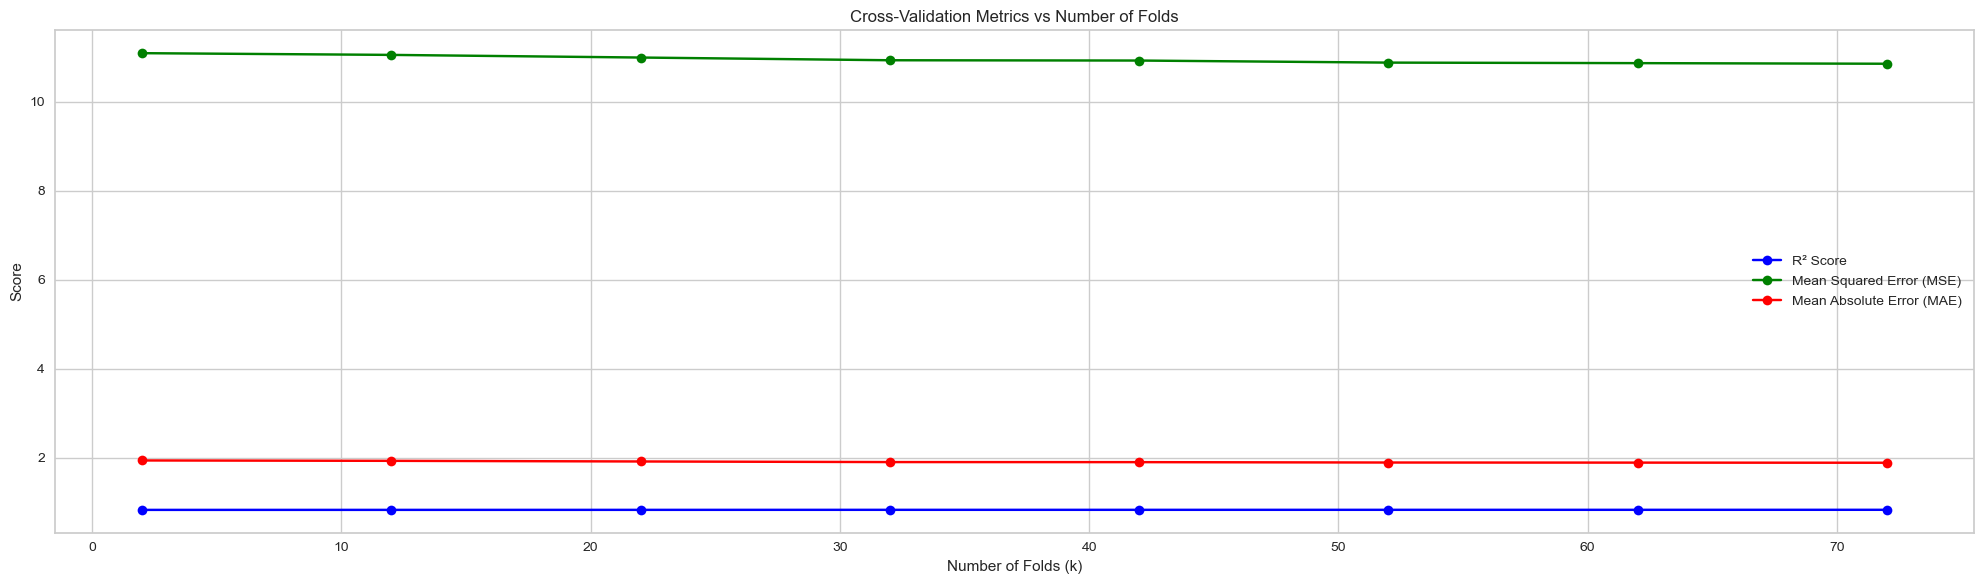

In [30]:
folds = []
mean_r2_scores = []
mean_mse_scores = []
mean_mae_scores = []

for i in range(8):
    model = LinearRegression()

    # Define custom scoring metrics for cross-validation
    scoring = {
        'R2': 'r2',  # R-squared score
        'MSE': make_scorer(mean_squared_error),  # Mean Squared Error
        'MAE': 'neg_mean_absolute_error',  # Negative Mean Absolute Error
    }

    # Perform cross-validation
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=i+2,  # Number of folds
        scoring=scoring,
        return_train_score=True
    )

    # Store results
    folds.append(10*i + 2)
    mean_r2_scores.append(cv_results['test_R2'].mean())
    mean_mse_scores.append(cv_results['test_MSE'].mean())
    mean_mae_scores.append(-cv_results['test_MAE'].mean())  # Negate MAE because it was negative

# Plot results
plt.figure(figsize=(20, 6))
plt.plot(folds, mean_r2_scores, label='R² Score', marker='o', color='blue')
plt.plot(folds, mean_mse_scores, label='Mean Squared Error (MSE)', marker='o', color='green')
plt.plot(folds, mean_mae_scores, label='Mean Absolute Error (MAE)', marker='o', color='red')

plt.xlabel('Number of Folds (k)')
plt.ylabel('Score')
plt.title('Cross-Validation Metrics vs Number of Folds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Reduced to  2 components
R² score:  0.018653510257093053
Mean Squared Error (MSE): 65.74874421185342
Mean Absolute Error (MAE): 5.490915498099458
______________________________________
Reduced to  3 components
R² score:  0.01941643349301503
Mean Squared Error (MSE): 65.69762949832848
Mean Absolute Error (MAE): 5.488283100389782
______________________________________
Reduced to  4 components
R² score:  0.8145299488309943
Mean Squared Error (MSE): 12.426215491395922
Mean Absolute Error (MAE): 1.9581792792098125
______________________________________
Reduced to  5 components
R² score:  0.8145503523182189
Mean Squared Error (MSE): 12.424848488327608
Mean Absolute Error (MAE): 1.95798613455523
______________________________________
Reduced to  6 components
R² score:  0.8166052916801415
Mean Squared Error (MSE): 12.287170630516838
Mean Absolute Error (MAE): 1.9370111854875636
______________________________________
Reduced to  7 components
R² score:  0.817035566866683
Mean Squared Error (MSE)

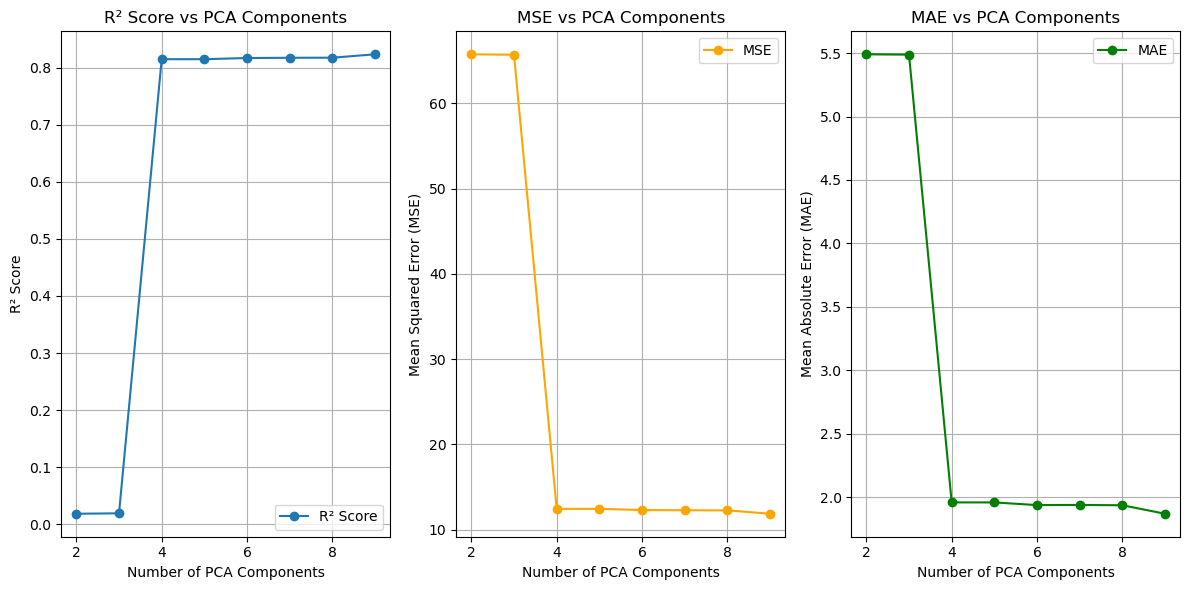

In [15]:
components = []
r2_scores = []
mse_list = []
mae_list = []

# Loop through different numbers of PCA components
for i in range(8):
    pca = PCA(n_components=i + 2)  # Incrementing the number of components
    # Fit and transform the data
    X_pca = pca.fit_transform(X)
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    second_linearRegressor = LinearRegression()
    second_linearRegressor.fit(X_train_pca, y_train)

    y_pred = second_linearRegressor.predict(X_test_pca)

    score = second_linearRegressor.score(X_test_pca, y_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Store results for plotting
    components.append(i + 2)
    r2_scores.append(score)
    mse_list.append(mse)
    mae_list.append(mae)

    # Print results
    print("Reduced to ", i + 2, "components")
    print("R² score: ", score)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print("______________________________________")

# Plot the results
plt.figure(figsize=(12, 6))

# R² Score plot
plt.subplot(1, 3, 1)
plt.plot(components, r2_scores, marker='o', label="R² Score")
plt.xlabel("Number of PCA Components")
plt.ylabel("R² Score")
plt.title("R² Score vs PCA Components")
plt.grid(True)
plt.legend()

# MSE plot
plt.subplot(1, 3, 2)
plt.plot(components, mse_list, marker='o', label="MSE", color='orange')
plt.xlabel("Number of PCA Components")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs PCA Components")
plt.grid(True)
plt.legend()

# MAE plot
plt.subplot(1, 3, 3)
plt.plot(components, mae_list, marker='o', label="MAE", color='green')
plt.xlabel("Number of PCA Components")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs PCA Components")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()





n_neighbors: 5
R² Score: 0.8999111481739928
MSE: 6.705803083771425
MAE: 0.829484489773873
----------------------------------------
n_neighbors: 7
R² Score: 0.900097363270651
MSE: 6.6933269513487375
MAE: 0.8256614318635419
----------------------------------------
n_neighbors: 9
R² Score: 0.9005346730624324
MSE: 6.664027850631821
MAE: 0.8257341276985615
----------------------------------------
n_neighbors: 11
R² Score: 0.9001577659061544
MSE: 6.689280065286637
MAE: 0.8285520815602372
----------------------------------------
n_neighbors: 13
R² Score: 0.8995192757188137
MSE: 6.732057951026299
MAE: 0.8315037662449174
----------------------------------------


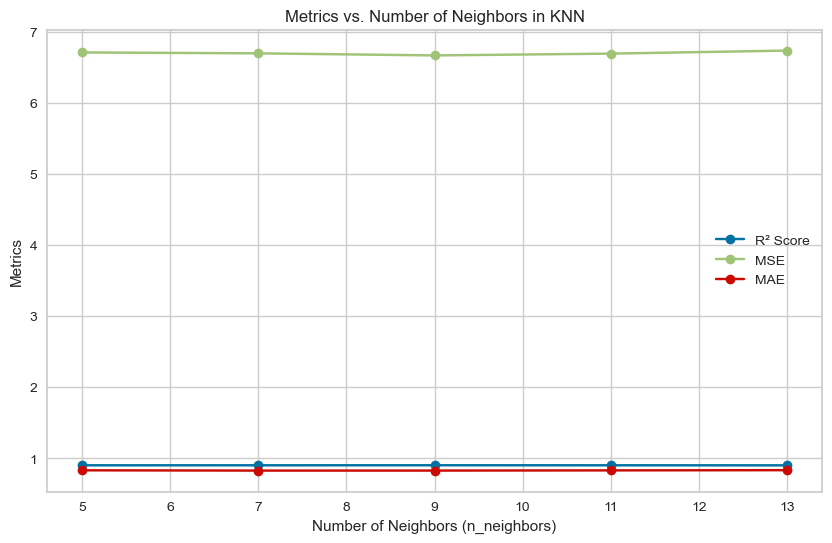

In [34]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define number of iterations and metrics lists
iterations = 5
scores = []  # R^2 scores
mses = []    # Mean Squared Errors
maes = []    # Mean Absolute Errors

# Loop over different values of n_neighbors
for i in range(iterations):
    n_neighbors = 5 + 2 * i
    knnModel = KNeighborsRegressor(n_neighbors=n_neighbors)
    knnModel.fit(X_train, y_train)
    
    # Make predictions
    y_pred = knnModel.predict(X_test)
    
    # Compute metrics
    score = knnModel.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store metrics
    scores.append(score)
    mses.append(mse)
    maes.append(mae)
    
    # Print results
    print(f"n_neighbors: {n_neighbors}")
    print(f"R² Score: {score}")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print("-" * 40)

# Plot the metrics
n_neighbors_values = [5 + 2 * i for i in range(iterations)]

plt.figure(figsize=(10, 6))

# Plot R^2 scores
plt.plot(n_neighbors_values, scores, label="R² Score", marker='o')

# Plot MSE
plt.plot(n_neighbors_values, mses, label="MSE", marker='o')

# Plot MAE
plt.plot(n_neighbors_values, maes, label="MAE", marker='o')

# Labels and legend
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Metrics")
plt.title("Metrics vs. Number of Neighbors in KNN")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


Alpha: 0.5, L1 Ratio: 0.1
Score: 0.7321961426681955, MSE: 17.94245712263094, MAE: 2.6676921454036524
Alpha: 0.5, L1 Ratio: 0.30000000000000004
Score: 0.7520665056498779, MSE: 16.61117257967449, MAE: 2.523917286008956
Alpha: 0.5, L1 Ratio: 0.5000000000000001
Score: 0.7725161029763234, MSE: 15.241080203632958, MAE: 2.3645305794183615
Alpha: 0.5, L1 Ratio: 0.7000000000000001
Score: 0.7907269331055593, MSE: 14.020981874890456, MAE: 2.2151637519035696
Alpha: 0.5, L1 Ratio: 0.9000000000000001
Score: 0.8049909011736139, MSE: 13.06531738966031, MAE: 2.0887373880953226
Alpha: 0.6, L1 Ratio: 0.1
Score: 0.711033667982166, MSE: 19.36031121347922, MAE: 2.8108468448968607
Alpha: 0.6, L1 Ratio: 0.30000000000000004
Score: 0.7332511364940874, MSE: 17.871774117261644, MAE: 2.6596420991333916
Alpha: 0.6, L1 Ratio: 0.5000000000000001
Score: 0.7572667855094507, MSE: 16.262761621984428, MAE: 2.4836645751847706
Alpha: 0.6, L1 Ratio: 0.7000000000000001
Score: 0.7813240229029184, MSE: 14.650962767696653, MAE: 

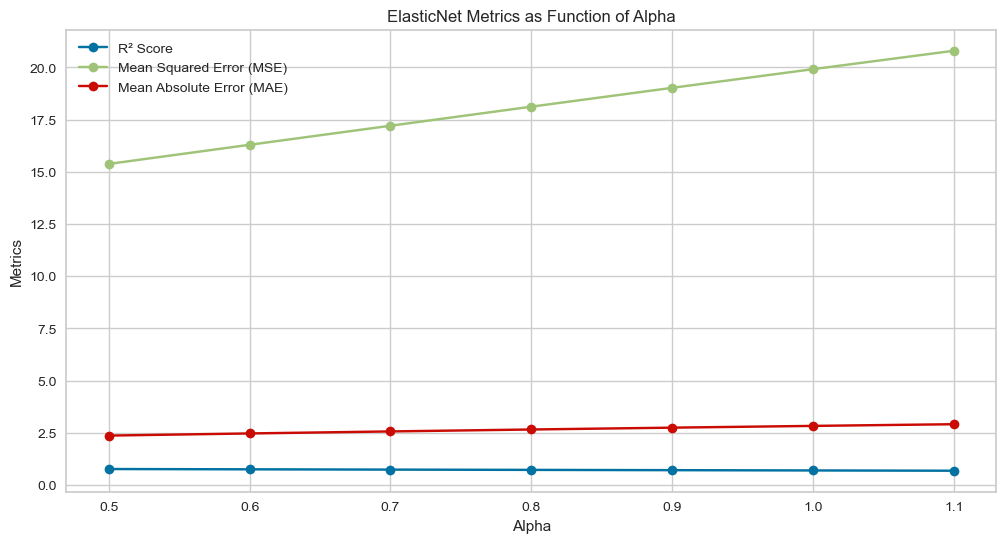

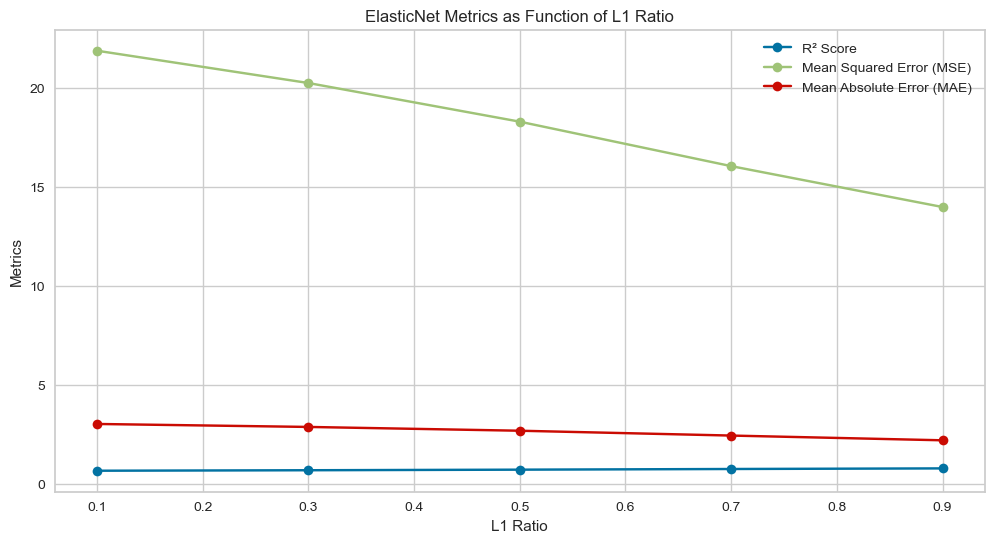

In [32]:
# Data Preparation
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train1_scaled = scaler.fit_transform(X_train1)
X_test1_scaled = scaler.transform(X_test1)

# Hyperparameter Ranges
alpha_values = np.arange(0.5, 1.1, 0.1)  # 0.5 to 1.0, step of 0.1
l1_ratio_values = np.arange(0.1, 1.1, 0.2)  # 0.1 to 1.0, step of 0.2

# Initialize lists to store results
scores = []
mse_list = []
mae_list = []

# Loop over hyperparameters
for alpha in alpha_values:
    for l1_ratio in l1_ratio_values:
        print(f"Alpha: {alpha}, L1 Ratio: {l1_ratio}")
        eNet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=5000, tol=1e-3)
        eNet.fit(X_train1_scaled, y_train1)
        
        # Predict
        y_pred = eNet.predict(X_test1_scaled)
        
        # Compute metrics
        score = eNet.score(X_test1_scaled, y_test1)
        mse = mean_squared_error(y_test1, y_pred)
        mae = mean_absolute_error(y_test1, y_pred)
        
        # Append results
        scores.append(score)
        mse_list.append(mse)
        mae_list.append(mae)
        
        print(f"Score: {score}, MSE: {mse}, MAE: {mae}")

# Reshape the results for easier plotting
scores_array = np.array(scores).reshape(len(alpha_values), len(l1_ratio_values))
mse_array = np.array(mse_list).reshape(len(alpha_values), len(l1_ratio_values))
mae_array = np.array(mae_list).reshape(len(alpha_values), len(l1_ratio_values))

# Plot Results for Alpha
plt.figure(figsize=(12, 6))
plt.plot(alpha_values, scores_array.mean(axis=1), label="R² Score", marker='o')
plt.plot(alpha_values, mse_array.mean(axis=1), label="Mean Squared Error (MSE)", marker='o')
plt.plot(alpha_values, mae_array.mean(axis=1), label="Mean Absolute Error (MAE)", marker='o')

plt.xlabel("Alpha")
plt.ylabel("Metrics")
plt.title("ElasticNet Metrics as Function of Alpha")
plt.legend()
plt.grid(True)
plt.show()

# Plot Results for L1 Ratio
plt.figure(figsize=(12, 6))
plt.plot(l1_ratio_values, scores_array.mean(axis=0), label="R² Score", marker='o')
plt.plot(l1_ratio_values, mse_array.mean(axis=0), label="Mean Squared Error (MSE)", marker='o')
plt.plot(l1_ratio_values, mae_array.mean(axis=0), label="Mean Absolute Error (MAE)", marker='o')

plt.xlabel("L1 Ratio")
plt.ylabel("Metrics")
plt.title("ElasticNet Metrics as Function of L1 Ratio")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Define the criteria to test
criteria = ['squared_error', 'friedman_mse', 'poisson']

# Split the dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Loop over criteria
for criterion in criteria:
    # Initialize and train the DecisionTreeRegressor
    treeRegressor = DecisionTreeRegressor(
        criterion=criterion,
        splitter='best',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        random_state=42,
    )
    treeRegressor.fit(X_train1, y_train1)
    
    # Make predictions
    y_pred = treeRegressor.predict(X_test1)
    
    # Compute metrics
    score = treeRegressor.score(X_test1, y_test1)
    mse = mean_squared_error(y_test1, y_pred)
    mae = mean_absolute_error(y_test1, y_pred)
    
    # Print results
    print(f"Criterion: {criterion}")
    print(f"R² Score: {score}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print("-" * 40)


Criterion: squared_error
R² Score: 0.9328963079969215
Mean Squared Error (MSE): 4.495846805685583
Mean Absolute Error (MAE): 0.6960304893417838
----------------------------------------
Criterion: friedman_mse
R² Score: 0.9321938384150424
Mean Squared Error (MSE): 4.542911214982717
Mean Absolute Error (MAE): 0.6980049600316874
----------------------------------------
Criterion: poisson
R² Score: 0.932360123552134
Mean Squared Error (MSE): 4.531770359984876
Mean Absolute Error (MAE): 0.6966761036295557
----------------------------------------
